## Setup

In [1]:
cd("$(homedir())/OneDrive/Documents/GitHub/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\Andrea\OneDrive\Documents\GitHub\enso_project.jl`


In [2]:
using CSV, DataFrames, NODEData, SciMLBase, SciMLSensitivity, Random, Flux, OrdinaryDiffEq, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\Andrea\.julia\packages\Flux\3711C\ext\FluxCUDAExt\FluxCUDAExt.jl:10
┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   Base.PkgId(Base.UUID("e3ecd195-ca82-5397-9546-f380c1e34951"), "NonlinearSolveBaseSparseMatrixColoringsExt")
│   Base.PkgId(Base.UUID("385e4588-a1a0-5c1d-98fa-d45bf6f8ecf9"), "LinearSolveKernelAbstractionsExt")
│   Base.PkgId(Base.UUID("3bcf3b12-2128-5d18-8b3b-bcdd6f83637b"), "WeightInitializersGPUArraysExt")
│   Base.PkgId(Base.UUID("b00db79b-61e3-50fb-b26f-2d35b2d9e4ed"), "DiffEqBaseChainRulesCoreExt")
│   Base.PkgId(Base.UUID("8913a72c-1f9b-4ce2-8d82-65094dcecaec"), "NonlinearSolve")
│   Base.PkgId(Base.UUID("7edab7de-1038-5e4f-97a7-6bfc75d44324"), "NonlinearSolveQuasiNewt

### Data preparation

In [3]:
# read and convert data to appropriate format for all splits
splits = [20,40,50,60,70,80]
data = Dict() # of tuples (time,data)

for s in splits

    # set dict keys
    key_train = "train_data_$s"
    key_test = "test_data_$s"
    key_val = "val_data_$s"

    # read input data
    data[key_train] = CSV.read("data/sst_34_data_split_$s/train_sst_34_anomaly_embedded_$s.txt", DataFrame; delim=',', ignorerepeated=true)
    data[key_test] = CSV.read("data/sst_34_data_split_$s/test_sst_34_anomaly_embedded_$s.txt", DataFrame; delim=',', ignorerepeated=true)
    data[key_val] = CSV.read("data/sst_34_data_split_$s/val_sst_34_anomaly_embedded_$s.txt", DataFrame; delim=',', ignorerepeated=true)
   
    # format data, make sure everything is Float32
    data[key_train] = (time = Float32.(0:size(data[key_train],1)-1), data = Float32.(permutedims(data[key_train])))
    data[key_test] = (time = Float32.(0:size(data[key_test],1)-1), data = Float32.(permutedims(data[key_test])))
    data[key_val] = (time = Float32.(0:size(data[key_val],1)-1), data = Float32.(permutedims(data[key_val])))
end

data

Dict{Any, Any} with 18 entries:
  "val_data_60"   => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "val_data_20"   => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "train_data_70" => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "test_data_40"  => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "test_data_20"  => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "train_data_80" => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "test_data_80"  => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "test_data_50"  => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "val_data_50"   => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "train_data_20" => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "val_data_70"   => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "test_data_70"  => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 

### Storage for prediction results

We carry out predictions for 6 different data splits, where we keep the size of the test set always at the same proportion of 10%, thus we need a storage matrix of size: 6 x test set size

In [4]:
predictions_of_data_splits = zeros(6, length(data["test_data_20"].time))

6×49 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

## Train and Validate

### Hyperparameter range

Chosen based on hyperparameter optimization setup for package ChaoticNDETools.jl

In [5]:
sampler = enso_project.RandomSampler(N_weights=10:30, N_hidden_layers=1:4, activation=["relu","swish"], τ_max=2:4, eta=[1f-2,1f-3,1f-4])
N_epochs = 30
N_samples = 15
seeds = Vector(111:111:N_samples*111) # for reproducibility of results

15-element Vector{Int64}:
  111
  222
  333
  444
  555
  666
  777
  888
  999
 1110
 1221
 1332
 1443
 1554
 1665

### Training data split 20%

train = 20%,
val =  70%,
test = 10%

In [6]:
# convert into NODEData format, intialize batch sizes arbitrarily
train = NODEDataloader(Array(data["train_data_20"].data), data["train_data_20"].time, 2)
valid = NODEDataloader(Array(data["val_data_20"].data), data["val_data_20"].time, 2)
test = NODEDataloader(Array(data["test_data_20"].data), data["test_data_20"].time, 2)

NODEData{Matrix{Float32},Int64} with 48 batches with length 2

In [7]:
opt_loss, opt_hpars, opt_pars = enso_project.train_and_validate_node(train, valid, N_samples, N_epochs, seeds, sampler)

starting training with N_EPOCHS= 30 - N_weights=18 - N_hidden_layers=2 - activation=relu - τ_max=2 - η=0.001
Validation MSE = 0.8521963
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=0.0001
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=6.25e-6
Validation MSE = 9.855358
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.8335096
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.7624681
starting training with N_EPOCHS= 30 - N_weights=19 - N_hidden_layers=4 - activation=swish - τ_max=2 - η=0.0001
Valida

((0.7269849f0, 6), Dict{Symbol, Any}(:N_hidden_layers => 2, :activation => "swish", :τ_max => 2, :N_weights => 22, :eta => 0.001f0), Float32[-0.056989737, 0.32404688, -0.3873647, 0.20208456, 0.2867657, -0.29667634, -0.13393652, -0.37251744, -0.31754398, 0.12967706  …  -0.5165339, 0.27118617, -0.26649374, -0.30623844, -0.2829004, -0.0047860164, -0.010755775, -0.015570271, -0.016370967, -0.012245096])

### Predicting data split 20%

##### Set up optimal model

In [ ]:
act_func = opt_hpars[:activation]
if act_func == "relu"
    activation = relu 
else
    activation = swish
end
p, re_nn = enso_project.setup_nn(opt_hpars[:N_weights],opt_hpars[:N_hidden_layers],activation,seeds[opt_loss[2]]) # network struct with optimal hyperpars

u0 = Vector(train.data[:,1])
dt = train.t[2] - train.t[1]
node_prob = enso_project.setup_node(opt_pars,re_nn,u0,dt) # NODE problem with optimal pars

model = enso_project.ChaoticNDE(node_prob)

enso_project.ChaoticNDE{Vector{Float32}, ODEProblem{Vector{Float32}, Tuple{Float32, Float32}, false, Vector{Float32}, ODEFunction{false, SciMLBase.FullSpecialize, enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, @NamedTuple{layers::NTuple{4, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}}}}}, LinearAlgebra.UniformScaling{Bool}, Nothing, enso_project.var"#basic_tgrad#9", Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, Base.Pairs{Symbol, Union{}

##### Evaluate optimal model

We are only interested in the model's forecasting performance on the testing set for the first dimension, the original time-series before embedding, which we have real-word measurement for.

In [ ]:
predictions_of_data_splits[1,:] = enso_project.predict_node(model, test, "20% Data Split")
predictions_of_data_splits

6×49 Matrix{Float64}:
 0.67  0.596934  0.516621  0.436734  …  -0.411612  -0.402516  -0.397154
 0.0   0.0       0.0       0.0           0.0        0.0        0.0
 0.0   0.0       0.0       0.0           0.0        0.0        0.0
 0.0   0.0       0.0       0.0           0.0        0.0        0.0
 0.0   0.0       0.0       0.0           0.0        0.0        0.0
 0.0   0.0       0.0       0.0       …   0.0        0.0        0.0

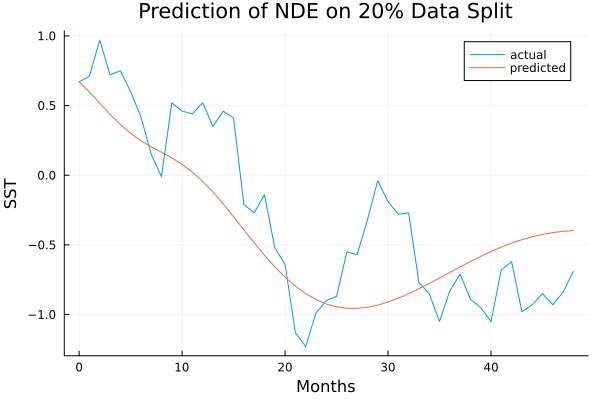

In [ ]:
using Plots
label = ["actual" "predicted"]
plt = plot(test.t, [test.data[1,:], prediction[1,:]], label=label, ylabel="SST", xlabel="Months", title="Prediction of NDE on 20% Data Split")
display(plt)

Calculate average forecast length, which is an evaluation metric of the model's forecasting performance.

Take whole test set into account.

In [ ]:
# all dimensions considered
enso_project.average_forecast_length(model, test.t, test.data, "all", length(test.t)-1; λ_max = 0, mode = "norm")

5.0

In [ ]:
# only first dimension considered
enso_project.average_forecast_length(model, test.t, test.data, "1D", length(test.t)-1; λ_max = 0, mode = "norm")

Save intermediate results for continuing work without having to rerun things:

In [20]:
using JLD2
save_object("data/model_20.jld2", model)

┌ Warning: Attempting to store enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, @NamedTuple{layers::NTuple{4, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}}}}}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store enso_project.var"#basic_tgrad#9".
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store ODEFunction{false, SciMLBase.FullSpecialize, enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(swish), Matrix{

In [22]:
model_pre = load_object("data/model_20.jld2")

enso_project.ChaoticNDE{Vector{Float32}, ODEProblem{Vector{Float32}, Tuple{Float32, Float32}, false, Vector{Float32}, ODEFunction{false, SciMLBase.FullSpecialize, enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, @NamedTuple{layers::NTuple{4, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}}}}}, LinearAlgebra.UniformScaling{Bool}, Nothing, enso_project.var"#basic_tgrad#9", Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, Base.Pairs{Symbol, Union{}

In [26]:
model_pre((test.t,test.data))[1,:] == prediction[1,:]

true